In [1]:
import cv2
import pyntcloud
import random
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import Terrain3dReconstruction as recon

%matplotlib inline
mpl.rcParams['figure.dpi']= 200

In [2]:
imgset=glob.glob("C:/Users/alouc/Desktop/Research Project/sfm from multi-view/datasets/templeRing/*.png")
n_imgs=len(imgset)
images, keypoints, descriptors = recon.find_features(imgset)
K = np.matrix('1520.40 0.00 302.32; 0.00 1525.90 246.87; 0.00 0.00 1.00')
matcher = cv2.BFMatcher(cv2.NORM_L1)
matches = recon.find_matches(matcher, keypoints, descriptors)
print('num_matches before outlier removal:', recon.num_matches(matches))
recon.print_num_img_pairs(matches)

matches = recon.remove_outliers(matches, keypoints)
print("After outlier removal:", recon.num_matches(matches))
recon.print_num_img_pairs(matches)

img_adjacency, list_of_img_pairs = recon.create_img_adjacency_matrix(n_imgs, matches)

num_matches before outlier removal: 59518
Number of img pairs is 1035 out of possible 1035
After outlier removal: 47762
Number of img pairs is 245 out of possible 1035


In [3]:
### This cell initializes the reconstruction
best_pair = recon.best_img_pair(img_adjacency, matches, keypoints, K, top_x_perc=0.2)
R0, t0, R1, t1, points3d_with_views = recon.initialize_reconstruction(keypoints, matches, K, best_pair[0], best_pair[1])

R_mats = {best_pair[0]: R0, best_pair[1]: R1}
t_vecs = {best_pair[0]: t0, best_pair[1]: t1}

resected_imgs = [best_pair[0], best_pair[1]] 
unresected_imgs = [i for i in range(len(images)) if i not in resected_imgs] 
print('initial image pair:', resected_imgs)
avg_err = 0

Triangulating: 433 points.
initial image pair: [20, 23]


In [4]:
### This cell grows and refines the reconstruction 
BA_chkpts = [3,4,5,6] + [int(6*(1.34**i)) for i in range(25)]
while len(unresected_imgs) > 0:
    resected_idx, unresected_idx, prepend = recon.next_img_pair_to_grow_reconstruction(n_imgs, best_pair, resected_imgs, unresected_imgs, img_adjacency)
    points3d_with_views, pts3d_for_pnp, pts2d_for_pnp, triangulation_status = recon.get_correspondences_for_pnp(resected_idx, unresected_idx, points3d_with_views, matches, keypoints)
    if len(pts3d_for_pnp) < 12:
        print(f"{len(pts3d_for_pnp)} is too few correspondences for pnp. Skipping imgs resected:{resected_idx} and unresected:{unresected_idx}")
        print(f"Currently resected imgs: {resected_imgs}, unresected: {unresected_imgs}")
        continue

    R_res = R_mats[resected_idx]
    t_res = t_vecs[resected_idx]
    print(f"Unresected image: {unresected_idx}, resected: {resected_idx}")
    R_new, t_new = recon.do_pnp(pts3d_for_pnp, pts2d_for_pnp, K)
    R_mats[unresected_idx] = R_new
    t_vecs[unresected_idx] = t_new
    if prepend == True: resected_imgs.insert(0, unresected_idx)
    else: resected_imgs.append(unresected_idx)
    unresected_imgs.remove(unresected_idx)
    pnp_errors, projpts, avg_err, perc_inliers = recon.test_reproj_pnp_points(pts3d_for_pnp, pts2d_for_pnp, R_new, t_new, K)
    print(f"Average error of reprojecting points used to resect image {unresected_idx} back onto it is: {avg_err}")
    print(f"Fraction of Pnp inliers: {perc_inliers} num pts used in Pnp: {len(pnp_errors)}")
    
    if resected_idx < unresected_idx:
        kpts1, kpts2, kpts1_idxs, kpts2_idxs = recon.get_aligned_kpts(resected_idx, unresected_idx, keypoints, matches, mask=triangulation_status)
        if np.sum(triangulation_status) > 0: #at least 1 point needs to be triangulated
            points3d_with_views, tri_errors, avg_tri_err_l, avg_tri_err_r = recon.triangulate_points_and_reproject(R_res, t_res, R_new, t_new, K, points3d_with_views, resected_idx, unresected_idx, kpts1, kpts2, kpts1_idxs, kpts2_idxs, reproject=True)
    else:
        kpts1, kpts2, kpts1_idxs, kpts2_idxs = recon.get_aligned_kpts(unresected_idx, resected_idx, keypoints, matches, mask=triangulation_status)
        if np.sum(triangulation_status) > 0: #at least 1 point needs to be triangulated
            points3d_with_views, tri_errors, avg_tri_err_l, avg_tri_err_r = recon.triangulate_points_and_reproject(R_new, t_new, R_res, t_res, K, points3d_with_views, unresected_idx, resected_idx, kpts1, kpts2, kpts1_idxs, kpts2_idxs, reproject=True)
    
    if 0.8 < perc_inliers < 0.95 or 5 < avg_tri_err_l < 10 or 5 < avg_tri_err_r < 10: 
        #If % of inlers from Pnp is too low or triangulation error on either image is too high, bundle adjust
        points3d_with_views, R_mats, t_vecs = recon.do_BA(points3d_with_views, R_mats, t_vecs, resected_imgs, keypoints, K, ftol=1e0)
        
    if len(resected_imgs) in BA_chkpts or len(unresected_imgs) == 0 or perc_inliers <= 0.8 or avg_tri_err_l >= 10 or avg_tri_err_r >= 10:
        #If % of inlers from Pnp is very low or triangulation error on either image is very high, bundle adjust with stricter tolerance
        points3d_with_views, R_mats, t_vecs = recon.do_BA(points3d_with_views, R_mats, t_vecs, resected_imgs, keypoints, K, ftol=1e-1)
    
    av = 0
    for im in resected_imgs:
        p3d, p2d, avg_error, errors = recon.get_reproj_errors(im, points3d_with_views, R_mats[im], t_vecs[im], K, keypoints, distCoeffs=np.array([]))
        print(f'Average reprojection error on image {im} is {avg_error} pixels')
        av += avg_error
    av = av/len(resected_imgs)
    print(f'Average reprojection error across all {len(resected_imgs)} resected images is {av} pixels')

Unresected image: 21, resected: 23
rvec: [[-0.16413482]
 [ 0.00283495]
 [ 0.01765777]] 

tvec: [[ 0.19310375]
 [-0.59092809]
 [ 0.04655499]]
Average error of reprojecting points used to resect image 21 back onto it is: 0.6246463629703684
Fraction of Pnp inliers: 0.9948320413436692 num pts used in Pnp: 387
Triangulating: 206 points.
Average reprojection error for just-triangulated points on image 21 is: 0.362442955897795 pixels.
Average reprojection error for just-triangulated points on image 23 is: 0.36055992705174333 pixels.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.4785e+02                                    1.59e+05    
       1              4         5.3092e+02      2.17e+02       8.17e-02       6.65e+04    
       2              5         4.4632e+02      8.46e+01       2.55e-01       1.79e+05    
       3              6         3.9128e+02      5.50e+01       1.77e-01       1.37e+05    
       4     

Unresected image: 18, resected: 19
rvec: [[ 0.23660842]
 [-0.02484466]
 [-0.03736962]] 

tvec: [[-0.01573593]
 [ 0.71887159]
 [ 0.07327392]]
Average error of reprojecting points used to resect image 18 back onto it is: 0.5353807493392683
Fraction of Pnp inliers: 0.9950738916256158 num pts used in Pnp: 406
Triangulating: 181 points.
Average reprojection error for just-triangulated points on image 18 is: 21.69366163152087 pixels.
Average reprojection error for just-triangulated points on image 19 is: 28.587487993041048 pixels.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.9580e+05                                    1.13e+06    
       1              2         1.4863e+04      3.81e+05       5.84e+00       8.42e+05    
       2              3         6.3270e+03      8.54e+03       7.98e-01       1.01e+06    
       3              4         3.6051e+03      2.72e+03       2.11e-01       2.65e+04    
       4      

       1              2         4.1075e+03      2.93e+03       3.56e-01       4.99e+04    
       2              3         4.1023e+03      5.25e+00       5.48e-02       1.14e+03    
`ftol` termination condition is satisfied.
Function evaluations 3, initial cost 7.0344e+03, final cost 4.1023e+03, first-order optimality 1.14e+03.
Average reprojection error on image 22 is 0.34448951386681287 pixels
Average reprojection error on image 21 is 0.166377051919113 pixels
Average reprojection error on image 20 is 0.24923035024270035 pixels
Average reprojection error on image 23 is 0.23698723074462058 pixels
Average reprojection error on image 24 is 0.15977009597451772 pixels
Average reprojection error on image 19 is 0.12016309971279616 pixels
Average reprojection error on image 25 is 0.14129438700440317 pixels
Average reprojection error on image 18 is 0.13535773204818252 pixels
Average reprojection error on image 26 is 0.1171231367190649 pixels
Average reprojection error on image 17 is 0.11924464

rvec: [[-1.15794362]
 [-0.02480872]
 [ 0.16834279]] 

tvec: [[ 0.28800883]
 [-3.00399715]
 [ 1.94115735]]
Average error of reprojecting points used to resect image 30 back onto it is: 0.8908210664096121
Fraction of Pnp inliers: 0.9965034965034965 num pts used in Pnp: 286
Triangulating: 132 points.
Average reprojection error for just-triangulated points on image 29 is: 0.13034982896365635 pixels.
Average reprojection error for just-triangulated points on image 30 is: 0.12872180242789022 pixels.
Average reprojection error on image 22 is 0.3453838284552354 pixels
Average reprojection error on image 21 is 0.1705401155911165 pixels
Average reprojection error on image 20 is 0.2548725211299905 pixels
Average reprojection error on image 23 is 0.24039987961812492 pixels
Average reprojection error on image 24 is 0.16775604226589702 pixels
Average reprojection error on image 19 is 0.12984729295358532 pixels
Average reprojection error on image 25 is 0.14997591397486704 pixels
Average reprojection 

rvec: [[-1.41792389]
 [-0.00645474]
 [ 0.20574504]] 

tvec: [[ 0.41219025]
 [-3.24738743]
 [ 2.76508281]]
Average error of reprojecting points used to resect image 32 back onto it is: 0.5682936855336833
Fraction of Pnp inliers: 1.0 num pts used in Pnp: 240
Triangulating: 196 points.
Average reprojection error for just-triangulated points on image 31 is: 6.2102323053736725 pixels.
Average reprojection error for just-triangulated points on image 32 is: 0.38533159770822883 pixels.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7466e+04                                    9.87e+05    
       1              2         5.1466e+03      1.23e+04       2.90e+00       8.22e+04    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 1.7466e+04, final cost 5.1466e+03, first-order optimality 8.22e+04.
Average reprojection error on image 22 is 0.3468104553249032 pixels
Average reprojection error o

rvec: [[-1.66766800e+00]
 [ 8.69969555e-04]
 [ 2.45823187e-01]] 

tvec: [[ 0.50155994]
 [-3.29641649]
 [ 3.35862945]]
Average error of reprojecting points used to resect image 34 back onto it is: 1.27302119715692
Fraction of Pnp inliers: 0.9961389961389961 num pts used in Pnp: 259
Triangulating: 151 points.
Average reprojection error for just-triangulated points on image 33 is: 0.18867603984161826 pixels.
Average reprojection error for just-triangulated points on image 34 is: 0.1867016387858444 pixels.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5633e+03                                    3.26e+05    
       1              3         6.5913e+03      1.97e+03       1.73e+00       1.97e+05    
       2              4         5.3455e+03      1.25e+03       1.19e+00       1.19e+05    
       3              6         5.2497e+03      9.58e+01       1.75e-01       3.99e+04    
`ftol` termination condition is satis

Unresected image: 36, resected: 35
rvec: [[-1.8415281 ]
 [-0.28434003]
 [-0.08331147]] 

tvec: [[ 0.65703526]
 [-3.14967773]
 [ 4.1738196 ]]
Average error of reprojecting points used to resect image 36 back onto it is: 2.1111423919298313
Fraction of Pnp inliers: 0.9825783972125436 num pts used in Pnp: 287
Triangulating: 149 points.
Average reprojection error for just-triangulated points on image 35 is: 0.6916261352800228 pixels.
Average reprojection error for just-triangulated points on image 36 is: 0.6985235352812175 pixels.
Average reprojection error on image 22 is 0.34675640942589514 pixels
Average reprojection error on image 21 is 0.17240529708204516 pixels
Average reprojection error on image 20 is 0.2586935604902722 pixels
Average reprojection error on image 23 is 0.24655976307149452 pixels
Average reprojection error on image 24 is 0.17490399113737948 pixels
Average reprojection error on image 19 is 0.13477327697750197 pixels
Average reprojection error on image 25 is 0.15860151472

rvec: [[ 1.75273583]
 [-0.02181737]
 [-0.28017118]] 

tvec: [[0.62173063]
 [3.18249977]
 [3.94526668]]
Average error of reprojecting points used to resect image 6 back onto it is: 1.0532363883359475
Fraction of Pnp inliers: 0.9868852459016394 num pts used in Pnp: 305
Triangulating: 90 points.
Average reprojection error for just-triangulated points on image 6 is: 0.17846980234535248 pixels.
Average reprojection error for just-triangulated points on image 7 is: 0.809720493885453 pixels.
Average reprojection error on image 22 is 0.34633580036504913 pixels
Average reprojection error on image 21 is 0.17212589191920918 pixels
Average reprojection error on image 20 is 0.25550869769518714 pixels
Average reprojection error on image 23 is 0.24661178872132888 pixels
Average reprojection error on image 24 is 0.17462260795465484 pixels
Average reprojection error on image 19 is 0.13458912751018307 pixels
Average reprojection error on image 25 is 0.15833068094522895 pixels
Average reprojection error 

Average reprojection error on image 35 is 0.16669814471771585 pixels
Average reprojection error on image 8 is 0.12279975619111433 pixels
Average reprojection error on image 36 is 0.15260373088351475 pixels
Average reprojection error on image 7 is 0.11760861937261374 pixels
Average reprojection error on image 37 is 0.19027150952127647 pixels
Average reprojection error on image 6 is 0.13736473878761557 pixels
Average reprojection error on image 38 is 0.24059652774763782 pixels
Average reprojection error on image 5 is 0.18257386698667089 pixels
Average reprojection error across all 34 resected images is 0.16852246858598607 pixels
Unresected image: 39, resected: 38
rvec: [[-1.04952051]
 [-0.0475178 ]
 [ 0.06255679]] 

tvec: [[ 0.81830281]
 [-2.50068161]
 [ 5.35094999]]
Average error of reprojecting points used to resect image 39 back onto it is: 0.49974943258603577
Fraction of Pnp inliers: 0.996875 num pts used in Pnp: 320
Triangulating: 134 points.
Average reprojection error for just-tria

Unresected image: 3, resected: 4
rvec: [[ 36.61626856]
 [ 38.18400447]
 [-11.21162343]] 

tvec: [[0.8511689 ]
 [1.33745635]
 [6.22230403]]
Average error of reprojecting points used to resect image 3 back onto it is: 1.3070447011741135
Fraction of Pnp inliers: 1.0 num pts used in Pnp: 258
Triangulating: 137 points.
Average reprojection error for just-triangulated points on image 3 is: 0.9808822256805759 pixels.
Average reprojection error for just-triangulated points on image 4 is: 0.9758995032952552 pixels.
Average reprojection error on image 22 is 0.3458960747238232 pixels
Average reprojection error on image 21 is 0.1708798556594138 pixels
Average reprojection error on image 20 is 0.24916262592743316 pixels
Average reprojection error on image 23 is 0.24585884681135028 pixels
Average reprojection error on image 24 is 0.17396755134697484 pixels
Average reprojection error on image 19 is 0.13347651163357296 pixels
Average reprojection error on image 25 is 0.1586316873778278 pixels
Average 

Average reprojection error on image 37 is 0.12916499576507356 pixels
Average reprojection error on image 6 is 0.135343435518482 pixels
Average reprojection error on image 38 is 0.1433585674393837 pixels
Average reprojection error on image 5 is 0.11471374712728796 pixels
Average reprojection error on image 39 is 0.1496643281313439 pixels
Average reprojection error on image 4 is 0.1189002780350203 pixels
Average reprojection error on image 40 is 0.14228550761665504 pixels
Average reprojection error on image 3 is 0.883021233288029 pixels
Average reprojection error on image 41 is 0.18588052587357262 pixels
Average reprojection error on image 2 is 0.6324721993507622 pixels
Average reprojection error across all 40 resected images is 0.18701530479485332 pixels
Unresected image: 42, resected: 41
rvec: [[-2.69927363]
 [ 0.00544147]
 [ 0.39356205]] 

tvec: [[ 0.9082287 ]
 [-1.36883436]
 [ 6.21597342]]
Average error of reprojecting points used to resect image 42 back onto it is: 1.006756434982154

rvec: [[-2.84146131]
 [ 0.00430202]
 [ 0.425059  ]] 

tvec: [[ 0.93452533]
 [-0.90896781]
 [ 6.40249567]]
Average error of reprojecting points used to resect image 43 back onto it is: 0.503661931448174
Fraction of Pnp inliers: 0.9966101694915255 num pts used in Pnp: 295
Triangulating: 219 points.
Average reprojection error for just-triangulated points on image 42 is: 6.327359505312505 pixels.
Average reprojection error for just-triangulated points on image 43 is: 0.7384541944886888 pixels.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3578e+04                                    1.47e+06    
       1              2         6.4220e+03      1.72e+04       4.71e+00       1.05e+05    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 2.3578e+04, final cost 6.4220e+03, first-order optimality 1.05e+05.
Average reprojection error on image 22 is 0.34516767093673706 pixels
Average reproje

Average reprojection error on image 36 is 0.14309762162557374 pixels
Average reprojection error on image 7 is 0.10850896186790758 pixels
Average reprojection error on image 37 is 0.13531796141080732 pixels
Average reprojection error on image 6 is 0.13680325083580488 pixels
Average reprojection error on image 38 is 0.1525624444602425 pixels
Average reprojection error on image 5 is 0.13277361275194305 pixels
Average reprojection error on image 39 is 0.16252521227130767 pixels
Average reprojection error on image 4 is 0.10395389459903735 pixels
Average reprojection error on image 40 is 0.1618599351521604 pixels
Average reprojection error on image 3 is 0.10592269835821541 pixels
Average reprojection error on image 41 is 0.1646700171132746 pixels
Average reprojection error on image 2 is 0.18004007933785332 pixels
Average reprojection error on image 42 is 0.24307808105329998 pixels
Average reprojection error on image 1 is 0.6002476696717165 pixels
Average reprojection error on image 43 is 0.6

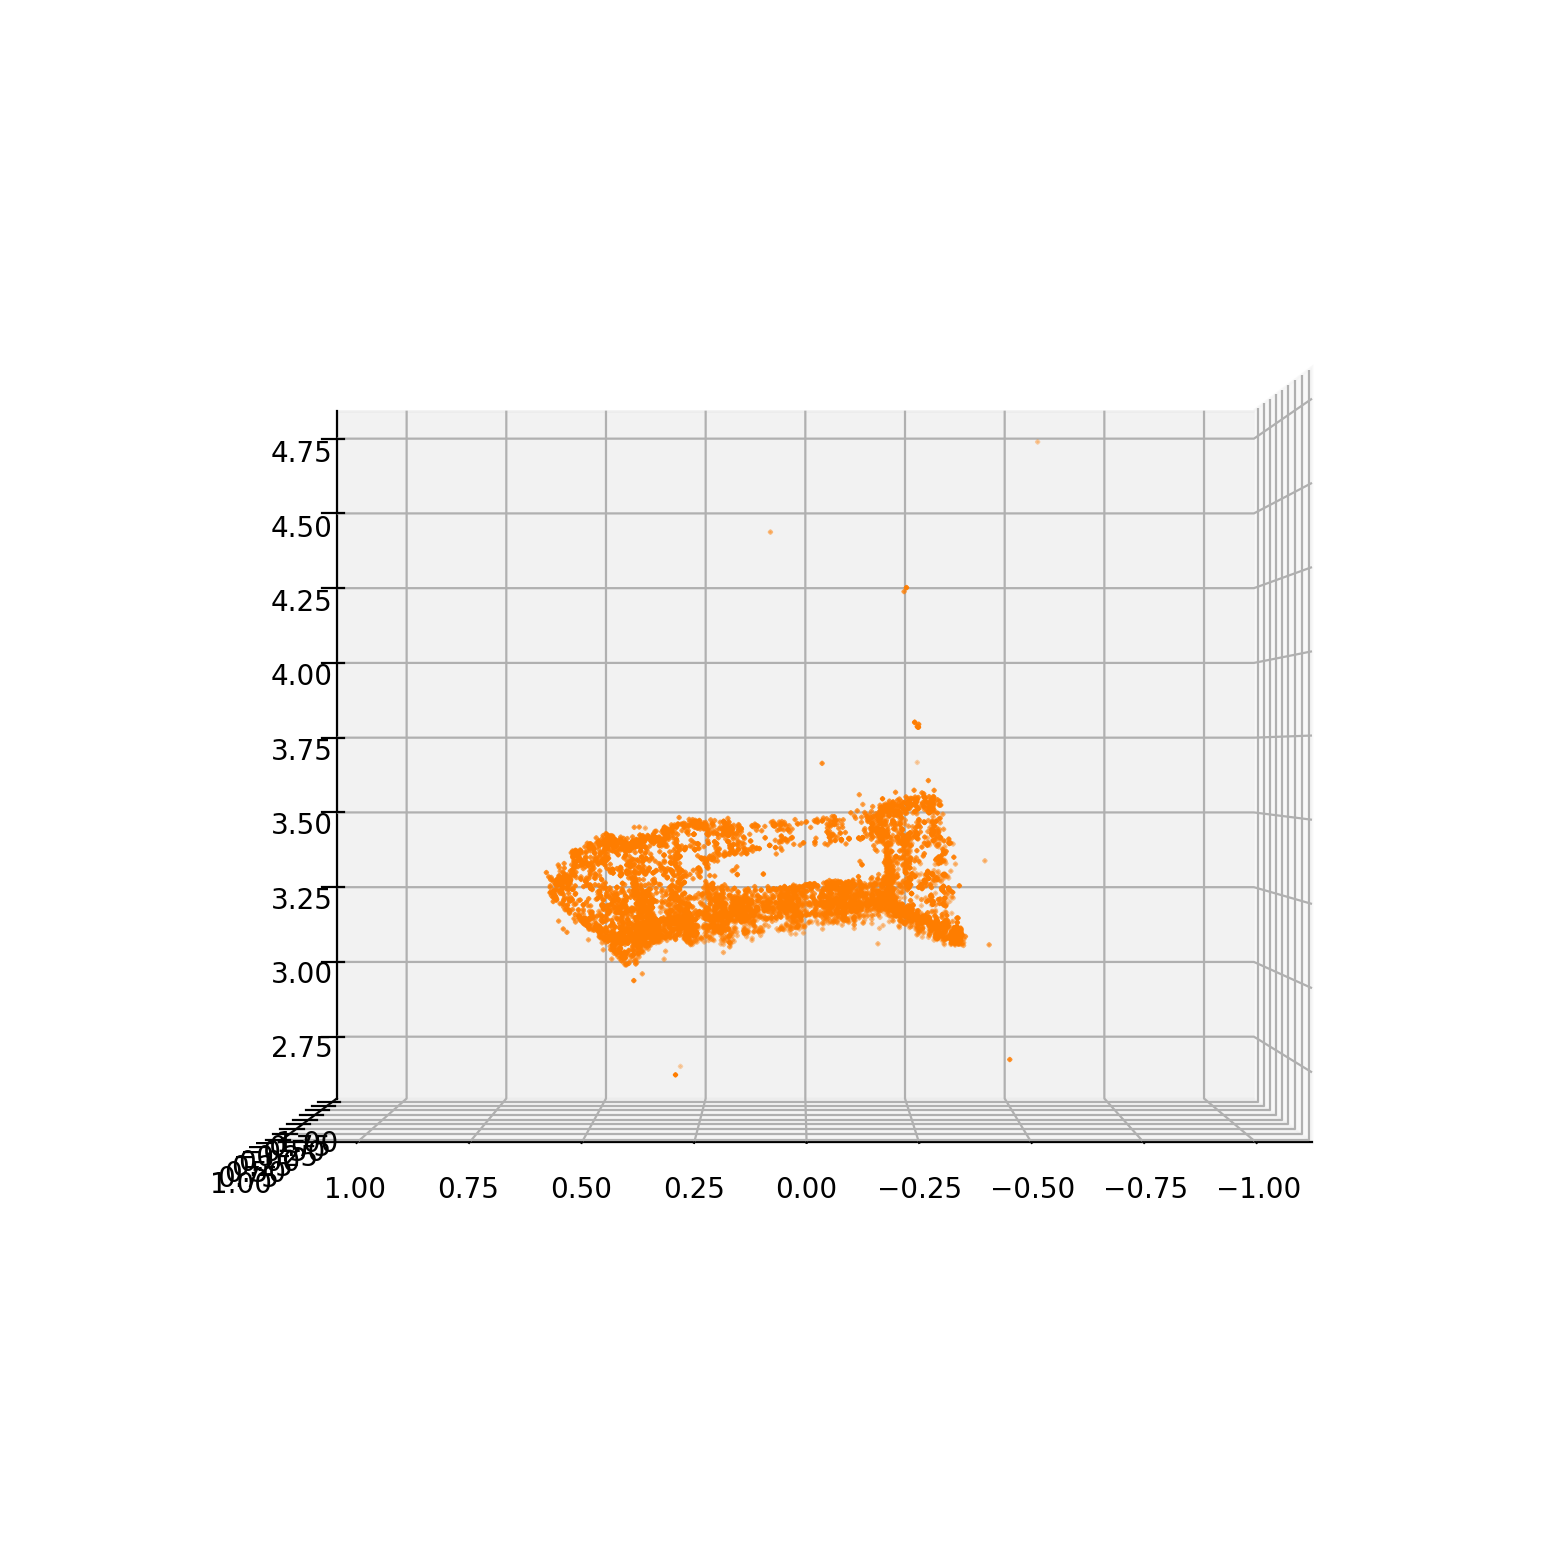

In [5]:
### This cell visualizes the pointcloud
num_voxels = 200 #Set to 100 for faster visualization, 200 for higher resolution.
x, y, z = [], [], []
for pt3 in points3d_with_views:
    if abs(pt3.point3d[0][0]) + abs(pt3.point3d[0][1]) + abs(pt3.point3d[0][2]) < 100:
        x.append(pt3.point3d[0][0])
        y.append(pt3.point3d[0][1])
        z.append(pt3.point3d[0][2])
vpoints = list(zip(x,y,z))
vpoints = np.array(vpoints)
vpoints_df = pd.DataFrame(data=vpoints, index=[f"{i}" for i in range(vpoints.shape[0])], columns=["x", "y","z"])
cloud = pyntcloud.PyntCloud(vpoints_df)
cloud.add_structure('voxelgrid', n_x=num_voxels,n_y=num_voxels,n_z=num_voxels)
cloud.plot()


In [9]:
cloud.to_file("C:/Users/alouc/Desktop/Research Project/sfm from multi-view/Results/result.ply")